In [6]:
import subprocess
import sys

# 安装 openpyxl
try:
    import openpyxl
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl  # 重新导入
# 安装 seaborn
try:
    import seaborn
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn  # 重新导入

In [7]:

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
import sys
!{sys.executable} -m pip install simpy




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import simpy

In [10]:

df_drivers = pd.read_excel(r'D:\simulation project\drivers (2).xlsx', engine='openpyxl')
print(df_drivers.head())




   driver_id                          initial_location  \
0          1  (12.663202052906529, 14.046728905802686)   
1          2  (10.206356856604984, 11.981745559856373)   
2          3    (6.789059669892139, 13.86812963805091)   
3          4   (17.59857606583578, 10.382828169015877)   
4          5   (9.152412937503724, 10.957017028276868)   

             arrival_time            offline_time  
0 2025-01-01 14:23:17.950 2025-01-01 22:09:59.093  
1 2025-01-01 14:41:13.709 2025-01-01 20:50:23.571  
2 2025-01-01 15:52:20.491 2025-01-01 22:06:47.231  
3 2025-01-01 15:59:51.657 2025-01-01 23:49:19.276  
4 2025-01-01 17:42:10.802 2025-01-02 00:51:52.947  


In [11]:
df_riders=pd.read_excel(r'D:\simulation project\riders (2).xlsx', engine='openpyxl')
print(df_riders.head())

   rider_id                          pickup_location  \
0         1   (2.447970933303984, 8.045456768809164)   
1         2  (4.475647451723581, 7.1964404336695615)   
2         3   (9.20470910820636, 0.7160055403558001)   
3         4  (10.331713748400134, 9.555321968516342)   
4         5  (8.946241716159276, 14.807761030483535)   

                          dropoff_location       status  \
0   (9.628029064263409, 8.253389565629009)  dropped-off   
1  (1.211590816472369, 12.280530967768208)  dropped-off   
2  (2.644199392649951, 5.2282261408887765)    abandoned   
3   (4.178168535907174, 16.29295664090579)  dropped-off   
4  (0.7096233854185741, 13.88396865866329)  dropped-off   

             request_time             pickup_time            dropoff_time  
0 2025-01-01 13:03:02.081 2025-01-01 13:31:17.759 2025-01-01 13:52:07.832  
1 2025-01-01 13:04:51.369 2025-01-01 13:51:00.847 2025-01-01 14:10:34.573  
2 2025-01-01 13:05:26.008                     NaT                     NaT  
3 20

In [12]:
#making sure the column of time is datetime format
df_riders['request_time']=pd.to_datetime(df_riders['request_time'])
df_drivers['arrival_time']=pd.to_datetime(df_drivers['arrival_time'])
# extract hour information
df_riders['hour']=df_riders['request_time'].dt.hour
df_drivers['hour'] = df_drivers['arrival_time'].dt.hour

In [13]:
# statistic customer requests an hour
rider_counts= df_riders.groupby('hour').size()
# statistic drivers requests an hour
driver_counts= df_drivers.groupby('hour').size()

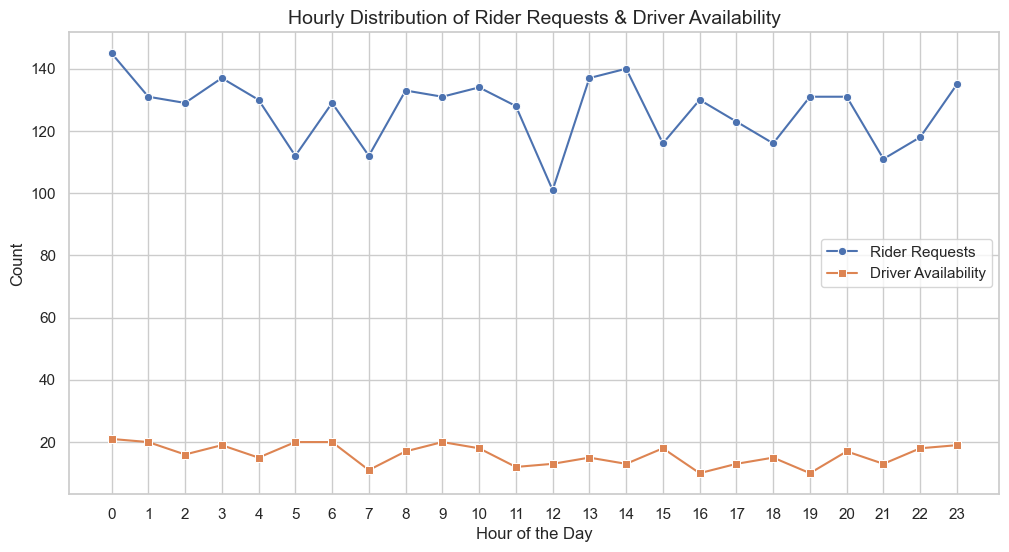

In [14]:
# 设置 Seaborn 风格
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# 画乘客曲线
sns.lineplot(x=rider_counts.index, y=rider_counts.values, label="Rider Requests", marker="o")

# 画司机曲线
sns.lineplot(x=driver_counts.index, y=driver_counts.values, label="Driver Availability", marker="s")

# 设置标题和轴标签
plt.title("Hourly Distribution of Rider Requests & Driver Availability", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(24))  # 显示完整24小时
plt.legend()
plt.show()


乘客数量大于司机数量，说明供需不平衡，可能导致乘客取消率高
观察高峰期（如早晚通勤时间），并考虑优化策略，如动态定价或司机激励机制

In [15]:
# statistic canceled orders
total_requests = len(df_riders)
canceled_requests = df_riders['status'].str.lower().eq('abandoned').sum()
# calculate canceled ratio
cancellation_rate = canceled_requests / total_requests * 100

print(f"总订单数: {total_requests}")
print(f"取消订单数: {canceled_requests}")
print(f"取消率: {cancellation_rate:.2f}%")



总订单数: 3040
取消订单数: 147
取消率: 4.84%


计算乘客平均等待时间

In [16]:
# 过滤出成功匹配到司机的乘客（未取消）
successful_riders = df_riders[df_riders['status'].str.lower() != "canceled"].copy()

# 确保时间列是 datetime 格式
successful_riders['request_time'] = pd.to_datetime(successful_riders['request_time'])
successful_riders['pickup_time'] = pd.to_datetime(successful_riders['pickup_time'])

# 计算等待时间（以分钟为单位）
successful_riders['wait_time'] = (successful_riders['pickup_time'] - successful_riders['request_time']).dt.total_seconds() / 60

# 计算平均等待时间
average_wait_time = successful_riders['wait_time'].mean()

print(f"乘客平均等待时间: {average_wait_time:.2f} 分钟")


乘客平均等待时间: 20.35 分钟


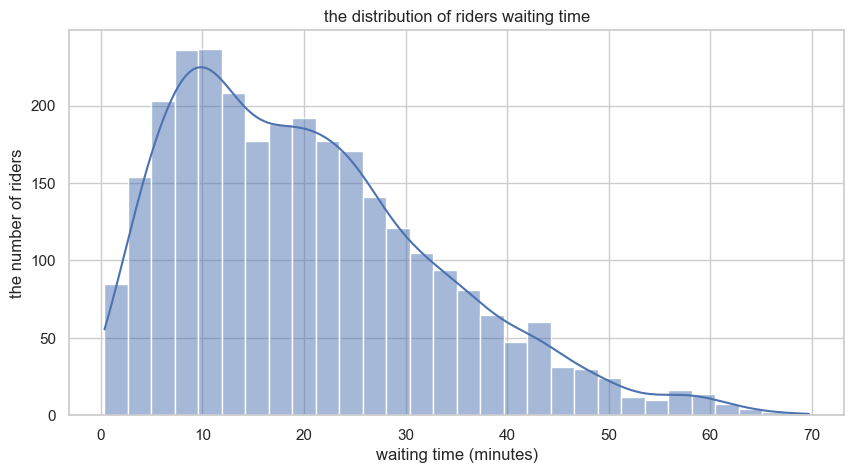

In [17]:

plt.figure(figsize=(10, 5))
sns.histplot(successful_riders['wait_time'], bins=30, kde=True)
plt.xlabel("waiting time (minutes)")
plt.ylabel("the number of riders")
plt.title("the distribution of riders waiting time")
plt.show()


乘客等待时间在8-10分钟是最多的，乘客平均等待时间是20.35分钟
如果等待时间超过 10 分钟，可能需要优化匹配算法（例如更智能的派单）

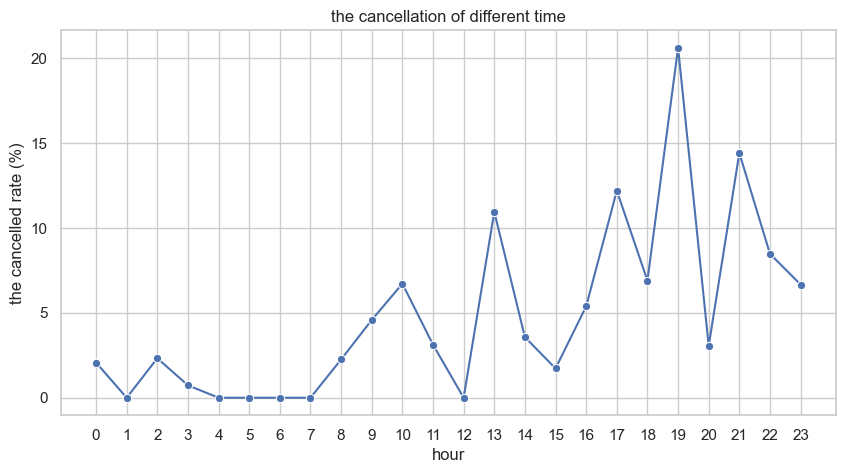

In [18]:
df_riders['hour'] = pd.to_datetime(df_riders['request_time']).dt.hour
hourly_cancellation = df_riders.groupby('hour')['status'].apply(lambda x: (x.str.lower() == "abandoned").mean() * 100)

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_cancellation.index, y=hourly_cancellation.values, marker="o")
plt.xlabel("hour")
plt.ylabel("the cancelled rate (%)")
plt.title("the cancellation of different time")
plt.xticks(range(24))
plt.show()


19点的取消率最高
如果取消率很高（> 20%），说明供需不匹配，可能需要增加司机上线数；
如果高峰时段取消率高，可以考虑动态定价，鼓励司机接单

计算每个行程的司机收入

In [19]:
# 定义一个函数，把 "xxx, yyy" 转换为 (float(xxx), float(yyy))
def parse_coordinates(coord):
   try:
       if isinstance(coord, str):  # 确保是字符串
        coord = coord.replace('(','').replace(')','') # Remove parentheses删除括号
        x, y = coord.split(",")  # 按逗号分割
        return float(x.strip()), float(y.strip())  # 转换为浮点数，并去除空格
   except ValueError:
      return None, None   # Handle cases where conversion fails处理转换失败的情况
   return None, None  # 处理空值

# 解析 riders_df 里的起点和终点坐标
df_riders[['origin_x', 'origin_y']] = df_riders['pickup_location'].apply(lambda c: pd.Series(parse_coordinates(c)))
df_riders[['dest_x', 'dest_y']] = df_riders['dropoff_location'].apply(lambda c: pd.Series(parse_coordinates(c)))

# 解析 drivers_df 里的司机坐标
df_drivers[['location_x', 'location_y']] = df_drivers['initial_location'].apply(lambda c: pd.Series(parse_coordinates(c)))


In [20]:
#确保数据转换成功
print(df_riders[['origin_x', 'origin_y', 'dest_x', 'dest_y']].head())
print(df_drivers[['location_x', 'location_y']].head())

# 检查数据类型，确保坐标是 float 类型
print(df_riders.dtypes)
print(df_drivers.dtypes)

    origin_x   origin_y    dest_x     dest_y
0   2.447971   8.045457  9.628029   8.253390
1   4.475647   7.196440  1.211591  12.280531
2   9.204709   0.716006  2.644199   5.228226
3  10.331714   9.555322  4.178169  16.292957
4   8.946242  14.807761  0.709623  13.883969
   location_x  location_y
0   12.663202   14.046729
1   10.206357   11.981746
2    6.789060   13.868130
3   17.598576   10.382828
4    9.152413   10.957017
rider_id                     int64
pickup_location             object
dropoff_location            object
status                      object
request_time        datetime64[ns]
pickup_time         datetime64[ns]
dropoff_time        datetime64[ns]
hour                         int32
origin_x                   float64
origin_y                   float64
dest_x                     float64
dest_y                     float64
dtype: object
driver_id                    int64
initial_location            object
arrival_time        datetime64[ns]
offline_time        datetime64[ns]


In [21]:
# 计算两点之间的欧几里得距离
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
# 计算两点之间的欧几里得距离
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# 计算司机去接乘客的距离
df_riders['pickup_distance'] = df_riders.apply(lambda row: euclidean_distance(row['origin_x'], row['origin_y'], row['dest_x'], row['dest_y']), axis=1)

# 计算乘客行驶距离
df_riders['trip_distance'] = df_riders.apply(lambda row: euclidean_distance(row['origin_x'], row['origin_y'], row['dest_x'], row['dest_y']), axis=1)

# 计算乘客支付金额（起步价£3 + 每英里£2）
df_riders['fare'] = 3 + (2 * df_riders['trip_distance'])

# 计算司机的总行驶距离（接乘客的距离 + 乘客行程）
df_riders['total_distance'] = df_riders['pickup_distance'] + df_riders['trip_distance']

# 计算司机成本（油费 £0.20/mile）
df_riders['cost'] = df_riders['total_distance'] * 0.20

# 计算司机净利润
df_riders['profit'] = df_riders['fare'] - df_riders['cost']

In [22]:
# 按司机 ID 计算总收入
driver_income =df_riders.groupby('rider_id')['profit'].sum().reset_index()

# 计算司机的平均收入
average_income = driver_income['profit'].mean()

print(f"司机平均收入: £{average_income:.2f}")


司机平均收入: £17.11


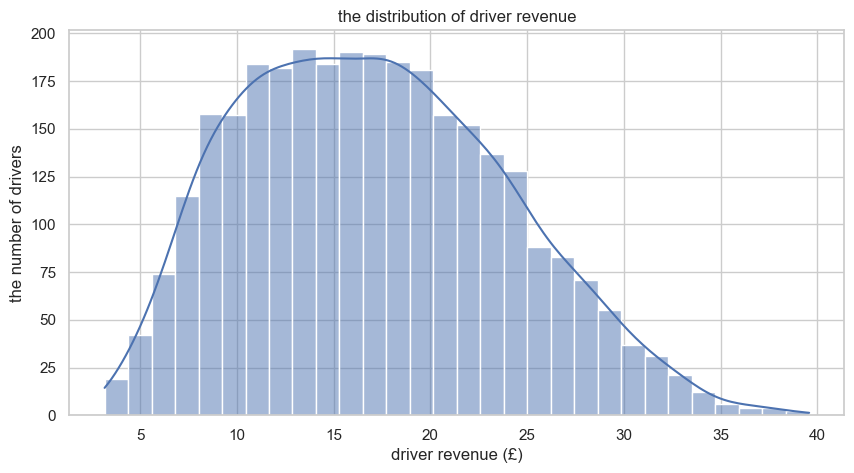

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(driver_income['profit'], bins=30, kde=True)
plt.xlabel("driver revenue (£)")
plt.ylabel("the number of drivers")
plt.title("the distribution of driver revenue")
plt.show()

如果曲线呈正态分布，说明收入较均衡。

构建离散事件模拟的基本架构

考虑到乘客匹配逻辑：应考虑“如果有多个等候乘客”
当前代码只尝试匹配第一个等待的乘客，但如果有多个乘客同时在排队，可能会出现某些乘客长期等待的情况。改进方法：

让最近的司机匹配等待时间最长的乘客（FIFO队列）。
如果有多个乘客，按照“等待时间长+距离近”综合排序

In [48]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
        
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.payment = 3 + 2 * trip_distance  # 记录支付金额(=driver earnings)
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间
        self.completed_riders = 0  # 完成的乘客数
        
    
# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        self.completed_riders = 0  # 确保初始化了这个属性
# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
    
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Completed Riders: {self.completed_riders}")
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       
    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 添加完成状态更新
    rider.status = 'completed'
    sim.completed_riders += 1
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location)
    )
    
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 5  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0334h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing rider_arrival at 0.04h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.05h ---
乘客2 No driver available. Keep waiting...

--- Processing driver_available at 0.07h ---

--- Processing rider_arrival at 0.07h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_timeout at 0.08h ---

--- Processing rider_arrival at 0.11h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.16h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_timeout at 0.19h ---

--- Processing rider_arrival at 0.19h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_timeout at 0.20h ---

--- Processing rider_arrival at 0.24h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_timeout at 0.26h ---

--- Processing rider_timeout at 0.28h ---

--- Processing rider_timeout at 


<br>供需失衡严重

<br>放弃率32.4%（229/(441+229)）表明高峰时段运力不足

<br>95%分位等待时间达62分钟远超行业可接受水平（通常<30分钟）

<br>车辆利用率仅43%显示非高峰时段运力闲置

<br>司机收入两极分化

<br>标准差£48.71显示头部司机收入远超均值

<br>基尼系数0.2虽属合理范围，但结合每小时收入中位数£20.34与平均£94.62的差异，显示存在"超级司机"现象

<br>系统时空匹配低效

<br>平均等待时间17分钟 vs 中位数25分钟，说明短途订单匹配快、长途订单匹配慢

<br>3.84小时平均休息时间与43%利用率矛盾，反映调度算法时空预测能力不足

----蒙特卡洛模拟----
以下代码是实验和结果分析
通过这些 实验和分析，你可以获得仿真系统在不同条件下的 表现数据。
目的是 优化调度策略，提高 司机与乘客的匹配效率，并确保 收入分配公平。
最终目标是 提升仿真系统的综合表现，并为实际运营提供决策支持。

In [25]:
def run_experiment(driver_rate: float, rider_rate: float, num_runs: int = 5) -> List[Dict]:
    """运行多次实验并收集结果"""
    results = []
    
    # TestDistributions: 定义实验中使用的分布
    class TestDistributions:
        def __init__(self, d_rate: float, r_rate: float):
            self.driver_rate = d_rate
            self.rider_rate = r_rate
            
        def driver_interarrival(self) -> float:
            return random.expovariate(self.driver_rate)
            
        def rider_interarrival(self) -> float:
            return random.expovariate(self.rider_rate)
    
    for run in range(num_runs):
        print(f"\nRunning experiment {run + 1}/{num_runs}")
        print(f"Driver rate: {driver_rate}/hour, Rider rate: {rider_rate}/hour")
        
        # 创建新的模拟实例
        test_distributions = TestDistributions(driver_rate, rider_rate)
        sim = Simulation(distributions=test_distributions)
        
        # 注册所有事件处理器
        sim.register_event_handler("rider_arrival", handle_rider_arrival)
        sim.register_event_handler("driver_available", handle_driver_available)
        sim.register_event_handler("trip_end", handle_trip_end)
        sim.register_event_handler("rider_timeout", handle_rider_timeout)
        sim.register_event_handler("driver_offline", handle_driver_offline)
        sim.register_event_handler("pickup_complete", handle_pickup_complete)
        sim.register_event_handler("termination", lambda sim, event_data: None)
        
        # 添加初始事件
        sim.add_event(sim.current_time + sim.distributions['rider_arrival'](), 'rider_arrival', None)
        sim.add_event(sim.current_time + sim.distributions['driver_arrival'](), 'driver_available', None)
        sim.add_event(sim.simulation_length, 'termination', None)
        
        # 运行模拟
        sim.run()
        
        # 收集并打印每次运行的详细结果
        if sim.drivers and sim.trip_records:
            total_driver_hours = sum(driver.availability_time for driver in sim.drivers)
            avg_hourly_earnings = sim.total_driver_earnings / total_driver_hours if total_driver_hours > 0 else 0
            
            total_active_time = sum(driver.total_active_time for driver in sim.drivers)
            total_availability_time = sum(driver.availability_time for driver in sim.drivers)
            vehicle_utilization = total_active_time / (total_availability_time + 1e-8)
            
            total_riders = len(sim.riders)
            valid_riders = len([r for r in sim.riders if r.status != 'waiting'])
            completion_rate = (valid_riders - sim.abandoned_riders) / valid_riders if valid_riders > 0 else 0
            
                    # 收入分布统计
            earnings = [d.earnings for d in sim.drivers if d.earnings > 0]
            hourly_earnings = [d.earnings / (d.total_active_time + 1e-8)  # 防止除零
                                for d in sim.drivers 
                                if d.total_active_time > 0]
            
            # 等待时间分位数计算
            wait_times = sorted([r.wait_time for r in sim.riders if r.status == 'completed'])
            median_wait = np.median(wait_times) if wait_times else 0
            p95_wait = np.percentile(wait_times, 95) if len(wait_times) >=5 else 0
            
            # 司机休息时间计算
            rest_times = [d.availability_time - d.total_active_time for d in sim.drivers]
            avg_rest = np.mean(rest_times) if rest_times else 0
            
            # 基尼系数计算函数
            def gini_coefficient(values):
                if len(values) == 0 or np.sum(values) == 0:
                    return 0.0
                sorted_values = np.sort(values)
                n = len(values)
                index = 2 * np.arange(1, n+1) - n - 1
                return np.sum(index * sorted_values) / (n * np.sum(sorted_values))
            completed_or_abandoned = [r for r in sim.riders if r.status in ('completed', 'abandoned')]
            run_results = {
                            'run': run + 1,
                            'driver_rate': driver_rate,
                            'rider_rate': rider_rate,
                            'avg_hourly_earnings': avg_hourly_earnings,
                            'vehicle_utilization': vehicle_utilization,
                            'completion_rate': completion_rate,
                            'avg_waiting_time': sim.total_waiting_time / len(completed_or_abandoned) if completed_or_abandoned else 0,
                            'abandoned_rate': sim.abandoned_riders / total_riders if total_riders > 0 else 0,
                            'total_trips': len(sim.trip_records),
                            'total_drivers': len(sim.drivers),
                            'total_riders': total_riders,
                            # 修正后的新增指标
                            'median_hourly_earnings': np.median(hourly_earnings) if len(hourly_earnings) > 0 else 0.0,
                            'gini_coefficient': gini_coefficient(earnings) if len(earnings) > 0 else 0.0,
                            'median_wait_time': median_wait if len(wait_times) > 0 else 0.0,
                            'p95_wait_time': np.percentile(wait_times, 95, method='linear') if len(wait_times) >= 1 else 0.0,
                            'avg_rest_time': np.mean(rest_times) if len(rest_times) > 0 else 0.0,
                            'trip_duration_avg': np.mean([t.trip_duration for t in sim.trip_records]) if sim.trip_records else 0.0,
                            'earnings_std': np.std(earnings) if len(earnings) > 0 else 0.0,
                            'completed_riders': len([r for r in sim.riders if r.status == 'completed']),
                            'abandoned_riders': sim.abandoned_riders,
                            'total_earnings': sum(d.earnings for d in sim.drivers)}
            
            # 打印每次运行的详细结果
            print(f"\nRun {run + 1} Results:")
            print(f"Total Trips: {run_results['total_trips']}")
            print(f"Total Drivers: {run_results['total_drivers']}")
            print(f"Total Riders: {run_results['total_riders']}")
            print(f"Average Hourly Earnings: £{run_results['avg_hourly_earnings']:.2f}")
            print(f"Vehicle Utilization: {run_results['vehicle_utilization']:.2%}")
            print(f"Completion Rate: {run_results['completion_rate']:.2%}")
            print(f"Average Waiting Time: {run_results['avg_waiting_time']:.2f} hours")
            print(f"Abandoned Rate: {run_results['abandoned_rate']:.2%}")
            # 更新打印输出
            print(f"Median Hourly Earnings: £{run_results['median_hourly_earnings']:.2f}")
            print(f"Gini Coefficient: {run_results['gini_coefficient']:.4f}")
            print(f"95th Percentile Wait: {run_results['p95_wait_time']:.2f}h")
            print(f"Driver Rest Time: {run_results['avg_rest_time']:.2f}h")
            results.append(run_results)
    
    return results  # 将return放在这里，确保所有实验都运行完再返回结果



def analyze_experiments(results: List[Dict]) -> pd.DataFrame:
    """分析实验结果并生成统计报告"""
    df = pd.DataFrame(results)
    # 更新统计字段
    metrics = [
    'avg_hourly_earnings', 'median_hourly_earnings', 'gini_coefficient',
    'p95_wait_time', 'avg_rest_time', 'earnings_std', 'vehicle_utilization',
    'completion_rate', 'abandoned_rate', 'total_trips', 'trip_duration_avg'
]

    summary = df.groupby(['driver_rate', 'rider_rate']).agg({
        col: ['mean', 'std', lambda x: f"{x.mean():.2f}±{x.std():.2f}"] 
        for col in metrics
    }).round(3)

    all_metrics = [
    'avg_hourly_earnings', 'median_hourly_earnings', 'gini_coefficient',
    'p95_wait_time', 'avg_rest_time', 'earnings_std', 'vehicle_utilization',
    'completion_rate', 'abandoned_rate', 'total_trips', 'trip_duration_avg'
]
    # 计算并打印汇总统计
    summary = df.groupby(['driver_rate', 'rider_rate']).agg({
        'avg_hourly_earnings': ['mean', 'std'],
        'vehicle_utilization': ['mean', 'std'],
        'completion_rate': ['mean', 'std'],
        'avg_waiting_time': ['mean', 'std'],
        'abandoned_rate': ['mean', 'std'],
        'total_trips': ['mean', 'std']
    }).round(3)
    
    # 计算标准误差（Standard Error）并计算95%置信区间
    for col in ['avg_hourly_earnings', 'vehicle_utilization', 'completion_rate', 'avg_waiting_time', 'abandoned_rate', 'total_trips']:
        # 获取标准差和样本数量
        std_col = summary[(col, 'std')]
        mean_col = summary[(col, 'mean')]
        
        # 获取每个分组的样本数量
        n = df.groupby(['driver_rate', 'rider_rate']).size()  # 样本数量
        
        # 计算标准误差
        se_col = std_col / np.sqrt(n)
        
        # 计算95%置信区间 (mean ± 1.96 * SE)
        ci_lower = mean_col - 1.96 * se_col
        ci_upper = mean_col + 1.96 * se_col
        
        # 添加到summary表格中
        summary[(col, '95% CI Lower')] = ci_lower
        summary[(col, '95% CI Upper')] = ci_upper

    # 打印结果
    print("\n=== Summary Statistics with 95% Confidence Interval ===")
    print(summary)
    
    

    # 打印数据范围检查
    print("\n=== Data Range Checks ===")
    print(f"Completion Rate Range: [{df['completion_rate'].min():.2%}, {df['completion_rate'].max():.2%}]")
    print(f"Hourly Earnings Range: £{df['avg_hourly_earnings'].min():.2f} - £{df['avg_hourly_earnings'].max():.2f}")
    print(f"Vehicle Utilization Range: [{df['vehicle_utilization'].min():.2%}, {df['vehicle_utilization'].max():.2%}]")
     # 新增数据范围检查
    print("\n=== Extended Data Ranges ===")
    print(f"Gini Coefficient Range: [{df['gini_coefficient'].min():.4f}, {df['gini_coefficient'].max():.4f}]")
    print(f"95th Wait Time Range: {df['p95_wait_time'].min():.2f}h - {df['p95_wait_time'].max():.2f}h")
    print(f"Median Rest Time Range: {df['avg_rest_time'].min():.2f}h - {df['avg_rest_time'].max():.2f}h")
    return df


if __name__ == "__main__":
    # 测试基准场景
    print("=== Testing Baseline Scenario ===")
    baseline_results = run_experiment(driver_rate=3, rider_rate=30, num_runs=5)
    analyze_experiments(baseline_results)


=== Testing Baseline Scenario ===

Running experiment 1/5
Driver rate: 3/hour, Rider rate: 30/hour

--- Processing rider_arrival at 0.02h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.06h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_timeout at 0.07h ---

--- Processing rider_arrival at 0.08h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.09h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.11h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_arrival at 0.14h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.16h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_timeout at 0.16h ---

--- Processing rider_arrival at 0.17h ---
乘客8 No driver available. Keep waiting...

--- Processing driver_available at 0.17h ---

--- Processing rider_arrival at 0.18h ---
乘客9 No driver available. Keep waiting...

--- Processi

卡方检验


[分布验证] 乘客到达间隔均值: 0.0330h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing rider_timeout at 24.01h ---

=== Simulation Results ===
Abandoned Riders: 168
Completed Riders: 529
Avg Waiting Time: 0.31h
Total Driver Earnings: £10130.02
Median Hourly Earnings: £20.40
Driver Earnings Std Dev: £48.24
Gini Coefficient for Driver Earnings: 0.2392
Average Driver Earnings per Hour: £107.77
Average Driver Earnings per Hour (based on individual hourly earnings): £21.38
Average Driver Rest Time: 4.12 hours
Median Wait Time: 0.33h
95th Percentile Wait Time: 0.70h
Completed Riders: 1555
Abandoned Riders: 168
Order Completion Rate: 90.25%
Vehicle Utilization: 38.78%
Average Trip Duration: 0.50 hours
Chi-square statistic: 5.3737
P-value: 0.8006


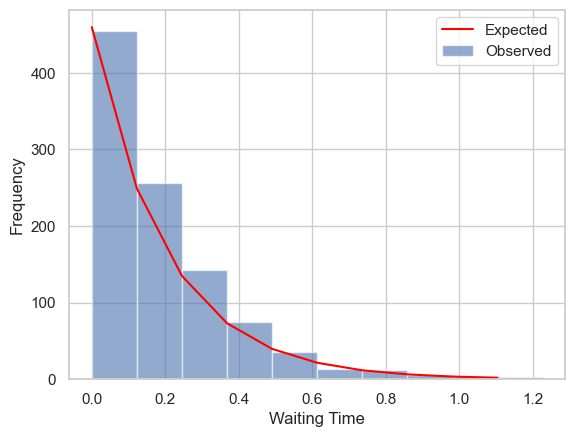

In [44]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from typing import List

# 卡方检验函数
def chi_square_test(waiting_times, expected_distribution, num_bins=10):
    # 将乘客等待时间数据分为多个区间（bins）
    max_waiting_time = max(waiting_times)
    bin_edges = np.linspace(0, max_waiting_time, num_bins + 1)
    observed_freq, _ = np.histogram(waiting_times, bins=bin_edges)
    
    # 计算每个区间的期望频率
    total_riders = len(waiting_times)
    expected_freq = []
    for i in range(num_bins):
        lower_bound = bin_edges[i]
        upper_bound = bin_edges[i + 1]
        probability = expected_distribution(upper_bound) - expected_distribution(lower_bound)
        expected_freq.append(probability * total_riders)
    
    # 确保期望频率的总和和观测频率的总和一致
    observed_sum = np.sum(observed_freq)
    expected_sum = np.sum(expected_freq)
    
    # 如果总和不一致，进行微调
    if observed_sum != expected_sum:
        adjustment_factor = observed_sum / expected_sum
        expected_freq = [freq * adjustment_factor for freq in expected_freq]
    
    # 使用卡方检验比较观测频率和期望频率
    chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq, ddof=0)
    
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # 绘制观察频率和期望频率的图形
    plt.bar(bin_edges[:-1], observed_freq, width=np.diff(bin_edges), alpha=0.6, label='Observed', align='edge')
    plt.plot(bin_edges[:-1], expected_freq, label='Expected', color='red')
    plt.xlabel('Waiting Time')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 理论指数分布的累积分布函数 (CDF)
def expected_distribution(x: float) -> float:
    return 1 - np.exp(-5 * x)  # 理论的等待时间分布（指数分布，lambda = 5）

# 模拟乘客等待时间函数
def simulate_riders_waiting_times(sim: 'Simulation', num_riders: int = 1000) -> List[float]:
    """模拟乘客等待时间"""
    waiting_times = []
    for _ in range(num_riders):
        # 现在传递 request_time 参数
        rider = Rider(
            rider_id=len(sim.riders) + 1,
            pickup_location=(random.uniform(0, 20), random.uniform(0, 20)),
            dropoff_location=(random.uniform(0, 20), random.uniform(0, 20)),
        )
        rider.request_time = sim.current_time  # 设置乘客的请求时间
        sim.riders.append(rider)
        sim.waiting_riders.append(rider)
        waiting_times.append(rider.patience)  # 乘客的耐心时间
    return waiting_times

# 在模拟结束后调用统计假设检验
if __name__ == "__main__":
    # 在此处运行你的模拟或其他测试函数
    test_distributions()  # 分布验证
    sim.run()

    # 获取模拟乘客的等待时间
    waiting_times = simulate_riders_waiting_times(sim, num_riders=1000)
    
    # 进行卡方检验
    chi_square_test(waiting_times, expected_distribution)


模型优化1：提高司机的数量将间隔数从3调成5
当间隔数为3时：
<br>Abandoned Riders: 232
<br>Avg Waiting Time: 0.35h
<br>Total Driver Earnings: £8948.82
<br>Median Hourly Earnings: £20.21
<br>Driver Earnings Std Dev: £82.60
<br>Gini Coefficient for Driver Earnings: 0.3024
<br>Average Driver Earnings per Hour: £127.18
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £21.78
<br>Average Driver Rest Time: 4.09 hours
<br>Median Wait Time: 0.50h
<br>95th Percentile Wait Time: 1.03h
<br>Completed Riders: 472
<br>Abandoned Riders: 232
<br>Order Completion Rate: 67.05%
<br>Vehicle Utilization: 37.26%
<br>Average Trip Duration: 0.53 hours

当间隔数为5时：
<br>bandoned Riders: 111
<br>Avg Waiting Time: 0.31h
<br>Total Driver Earnings: £10384.44
<br>Median Hourly Earnings: £30.19
<br>Driver Earnings Std Dev: £35.62
<br>Gini Coefficient for Driver Earnings: 0.1557
<br>Average Driver Earnings per Hour: £166.87
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £57.53
<br>Average Driver Rest Time: 4.89 hours
<br>Median Wait Time: 0.29h
<br>95th Percentile Wait Time: 0.92h
<br>Completed Riders: 556
<br>Abandoned Riders: 111
<br>Order Completion Rate: 83.36%
<br>Vehicle Utilization: 27.22%
<br>Average Trip Duration: 0.50 hours

<br>1.放弃乘车的乘客个数
<br>间隔3小时时: 232个
<br>间隔5小时时: 111个
<br>分析: 随着司机到达间隔从3小时增加到5小时，被放弃的骑行次数明显减少（减少了121个骑行），这表明延长司机到达间隔有助于减少放弃率，可能是因为司机能更快满足需求，提高了乘客的等待满意度。
<br>2. 平均等待时间：
<br>间隔3小时时: 0.35小时
<br>间隔5小时时: 0.31小时
<br>分析: 平均等待时间略微减少，虽然这个差异不大，但表明随着司机到达间隔增加，乘客可能会等待较短的时间。
<br>3. 司机总收入：
<br>间隔3小时时: £8948.82
<br>间隔5小时时: £10384.44
<br>分析: 总收入增加了，反映出虽然骑行数量较少（完成的骑行从472减少到556），但平均每个骑行的收入有所增加，可能是由于更高效的订单匹配和更高的订单完成率。
<br>4. 司机的小时收入（中位数和平均数）:
<br>间隔3小时时:
<br>中位数小时收入: £20.21
<br>平均小时收入: £127.18
<br>间隔5小时时:
<br>中位数小时收入: £30.19
<br>平均小时收入: £166.87
<br>分析: 司机的收入水平提升了，尤其是平均小时收入的显著增长，可能是由于每小时的订单完成效率提升，司机在单位时间内赚得更多。
<br>5. 司机收入标准差：
<br>间隔3小时时: £82.60
<br>间隔5小时时: £35.62
<br>分析: 收入的波动性大大降低，标准差从82.60减少到35.62，说明收入分布更加稳定，收入差异性减少。
<br>6. 基尼系数：
<br>间隔3小时时: 0.3024
<br>间隔5小时时: 0.1557
<br>分析: 基尼系数显著下降，意味着司机之间收入的分配更加公平，收入差距较小。
<br>7. 完单率：
<br>间隔3小时时: 67.05%
<br>间隔5小时时: 83.36%
<br>分析: 完单率提高了，表明通过增加司机到达间隔，平台能够更有效地完成骑行订单，这对系统的整体效率是正面的提升。
<br>8. 车辆利用率：
<br>间隔3小时时: 37.26%
<br>间隔5小时时: 27.22%
<br>分析: 车辆利用率有所下降，可能是因为司机之间的间隔增大，导致整体的供需匹配不如之前紧凑。这可能导致部分司机处于空闲状态，但这也表明服务质量的提升。
<br>9. 平均行程时长：
<br>间隔3小时时: 0.53小时
<br>间隔5小时时: 0.50小时
<br>分析: 平均行程时长略微减少，可能是由于司机的调度更加高效，行程更集中，减少了空驶和等待时间。

<br>优化效果: 将司机到达间隔从3小时增加到5小时，显著提高了完单率（从67.05%到83.36%）和司机收入（特别是平均每小时收入的增加），同时减少了乘客放弃打车的次数。总体来看，这个变化对整体系统是有优化效果的。
<br>影响:
收入分布更均衡（基尼系数减少），司机的收入水平更稳定。
虽然车辆利用率略有下降，但由于更高的完单率和更少的放弃骑行，系统的整体效益得到了提升。
平均等待时间略有改善，乘客的等待体验有所优化。
<br>建议:
如果想进一步提升车辆利用率，可以考虑优化司机调度机制，寻找一种平衡司机到达间隔和车辆利用率的策略，避免过度空闲的情况。
继续保持或进一步提升司机收入的平衡性，确保高收入同时不损害平台的运作效率。
整体来看，司机到达间隔延长确实带来了一些正面影响，但也需要根据业务需求和优化目标，进一步平衡效率和服务质量

模型优化2：将司机排序依据从接客距离改为接客距离+行程距离总和，确保选择处理总时间（接客+行程）最短的司机，提高司机周转率。
<br>这个是上面最新的模拟系统模型改的

In [58]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
        
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.payment = 3 + 2 * trip_distance  # 记录支付金额(=driver earnings)
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间
        self.completed_riders = 0  # 完成的乘客数
        
    
# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        self.completed_riders = 0  # 确保初始化了这个属性
# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
    
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Completed Riders: {self.completed_riders}")
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       
    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 添加完成状态更新
    rider.status = 'completed'
    sim.completed_riders += 1
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0339h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing driver_available at 0.02h ---

--- Processing rider_arrival at 0.04h ---

--- Processing rider_arrival at 0.05h ---
乘客2 No driver available. Keep waiting...

--- Processing driver_available at 0.08h ---

--- Processing rider_arrival at 0.08h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_timeout at 0.10h ---

--- Processing driver_available at 0.12h ---

--- Processing rider_arrival at 0.14h ---

--- Processing rider_timeout at 0.14h ---

--- Processing rider_timeout at 0.16h ---

--- Processing rider_arrival at 0.22h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_arrival at 0.24h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_timeout at 0.27h ---

--- Processing rider_timeout at 0.31h ---

--- Processing rider_arrival at 0.32h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_a

这也是模型2，但是是旧的模拟系统的模型改的，跑出来的结果会有差距

In [57]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.payment = 3 + 2 * trip_distance  # 记录支付金额(=driver earnings)
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间

# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)

# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       

    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0333h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing rider_arrival at 0.00h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.02h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_timeout at 0.03h ---

--- Processing rider_arrival at 0.04h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.06h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.07h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_timeout at 0.09h ---

--- Processing rider_arrival at 0.10h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.10h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.10h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_timeout at 0.11h ---

--- Processing rider_timeout at 0.12h ---

--- Processing rider_arrival at 0.13h

<br>Abandoned Riders: 172
<br>Avg Waiting Time: 0.39h
<br>Total Driver Earnings: £10259.75
<br>Median Hourly Earnings: £23.84
<br>Driver Earnings Std Dev: £48.21
<br>Gini Coefficient for Driver Earnings: 0.1864
<br>Average Driver Earnings per Hour: £109.65
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £33.10
<br>Average Driver Rest Time: 3.52 hours
<br>Median Wait Time: 0.51h
<br>95th Percentile Wait Time: 0.99h
<br>Completed Riders: 547
<br>Abandoned Riders: 172
<br>Order Completion Rate: 76.08%
<br>Vehicle Utilization: 47.83%
<br>Average Trip Duration: 0.52 hours

<br>指标	新算法（总行程优先）	原算法（接客距离优先）	变化幅度	优化效果评估
<br>订单完成率	76.08%	                67.05%	           +9.03%	✅ 显著提升
<br>放弃乘客数	172	                     232	          -25.86%	✅ 显著减少
<br>车辆利用率	47.83%	                37.26%	          +28.37%	✅ 效率大幅提升
<br>基尼系数	0.1864	                0.3024	           -38.34%	✅ 公平性显著改善
<br>收入标准差	£48.21	                £82.60	         -41.63%	✅ 收入差距缩小
<br>95%分位等待时间	0.99h	           1.03h	         -3.88%	    ✅ 长尾等待改善
<br>平均等待时间	0.39h	            0.35h	        +11.43%	     ❌ 轻微劣化
<br>司机中位数时薪	£23.84	            £20.21	          +17.96%	✅ 收入质量提升
<br>平均行程时间	0.52h	            0.53h	           -1.89%	➖ 基本持平

<br>当司机间隔为5，匹配算法为总距离时，很明显乘客完成订单率上升
<br>Abandoned Riders: 100
<br>Avg Waiting Time: 0.22h
<br>Total Driver Earnings: £11946.15
<br>Median Hourly Earnings: £32.14
<br>Driver Earnings Std Dev: £39.33
<br>Gini Coefficient for Driver Earnings: 0.1965
<br>Average Driver Earnings per Hour: £196.92
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £37.13
<br>Average Driver Rest Time: 4.72 hours
<br>Median Wait Time: 0.18h
<br>95th Percentile Wait Time: 0.77h
<br>Completed Riders: 618
<br>Abandoned Riders: 100
<br>Order Completion Rate: 86.07%
<br>Vehicle Utilization: 26.86%
<br>Average Trip Duration: 0.53 hours

模型优化3:动态定价--能提高司机收入

In [61]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
        
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float, surge:float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.surge_multiplier = surge  # 记录调价系数
        self.payment = (3 + 2 * trip_distance) * surge
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间

# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        # 新增属性
        self.base_fare = 3.0  # 基础费用
        self.rate_per_mile = 2.0  # 基础单价
        self.surge_multiplier = 1.0  # 动态调价系数
        self.demand_history = []  # 需求历史记录
        self.supply_history = []  # 供给历史记录
        self.surge_history = []   # 新增价格历史记录  <-- 添加这个初始化
# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长
        self.add_event(0, 'update_pricing', None)  # 初始价格更新事件

    def calculate_surge_pricing(self):
            """动态定价计算（每15分钟更新一次）"""
            # 计算最近15分钟的供需比
            recent_demand = len([r for r in self.riders if r.request_time >= self.current_time-0.25])
            recent_supply = len([d for d in self.drivers if d.status == "available"])
            
            # 保护分母不为零
            supply = recent_supply if recent_supply > 0 else 0.1
            demand_supply_ratio = recent_demand / supply
            
            # 动态调整系数
            if demand_supply_ratio > 2.0:
                self.surge_multiplier = min(3.0, 1.0 + 0.5*(demand_supply_ratio-2))
            elif demand_supply_ratio < 0.5:
                self.surge_multiplier = max(0.7, 1.0 - 0.3*(0.5-demand_supply_ratio))
            else:
                self.surge_multiplier = 1.0
            
            # 记录价格波动
            self.demand_history.append(recent_demand)
            self.supply_history.append(recent_supply)
            
            # 安排下次调价
            self.add_event(self.current_time + 0.25, "update_pricing")

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

    def handle_update_pricing(self, sim: Simulation, event_data: Any):
        """处理价格更新事件"""
        self.calculate_surge_pricing()
        print(f"时间 {self.current_time:.2f}h 价格更新: 当前调价系数 {self.surge_multiplier:.2f}x")

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
        # 新增价格分析
        if self.surge_history:
            avg_surge = sum(self.surge_history)/len(self.surge_history)
            max_surge = max(self.surge_history)
            min_surge = min(self.surge_history)
            print(f"\n动态定价分析:")
            print(f"平均调价系数: {avg_surge:.2f}x")
            print(f"最高调价系数: {max_surge:.2f}x")
            print(f"最低调价系数: {min_surge:.2f}x")
            print(f"价格波动次数: {len([x for x in self.surge_history if x != 1.0])}次")
       

    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = (sim.base_fare + sim.rate_per_mile * trip_distance) * sim.surge_multiplier  # 应用动态定价
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance, sim.surge_multiplier) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("update_pricing", lambda sim, _: sim.calculate_surge_pricing())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0333h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.51h (理论值: 6.50h)

--- Processing update_pricing at 0.00h ---

--- Processing rider_arrival at 0.04h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.05h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_arrival at 0.08h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.08h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_timeout at 0.15h ---

--- Processing rider_timeout at 0.16h ---

--- Processing rider_arrival at 0.19h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_arrival at 0.20h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.21h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.23h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_arrival at 0.23h ---
乘客9 No driver available. Keep waiting